# WMT Prophet

## Init 
- Bringing WMT's stock history 
- Backfilling and only getting business days
- Creating MAPE fn
- Adding features to data

In [15]:
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns
import yfinance
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

df_ticker_price = download_data(list_stocks=tickerList,start_date = '2016-01-01', end_date = '2024-09-30')
stock = 'AXP'
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)
monthly_data=to_month_and_add_monthYear_columns(df_ticker_price1)
printGraphs = 0 # 1 to show graphs

# selecting stock only - daily
stock_hist_daily = df_ticker_price1[[stock]]

#selecting stock only - monthly 
stock_hist = monthly_data[[stock,'month','year']].copy()

[*********************100%***********************]  30 of 30 completed


In [16]:

import pandas as pd 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Adding features to data: day, month, year, week nbr, etc...

In [18]:
### DAILY STOCKS
from function_filePrep import _add_dayMonthYear 

# add month, year, day of week, day of year...
stock_hist_daily1=_add_dayMonthYear(stock_hist_daily)

## Basic Prophet Model

- Add COVID lockdowns as holidays (hexogenous vars)
- Adds features as additive hexogenous vars 

In [24]:

stock_hist_daily2=stock_hist_daily1.reset_index().rename(columns={'Date':'ds',stock:'y'}).copy()
date_train_test = '2024-07-31'
stock_train2=stock_hist_daily2.loc[stock_hist_daily2.ds<=date_train_test].copy()
stock_test2=stock_hist_daily2.loc[stock_hist_daily2.ds>date_train_test].copy()

## COVID
# Python
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

## END COVID 
#changepoint range dice que encuentra cambios en trend hasta el 90% inicial de la data.
#m = Prophet(holidays=lockdowns, changepoint_range=0.9, changepoint_prior_scale=0.2) 
m = Prophet(holidays=lockdowns) 
# changepoint prior scale es que tan flexible es. valores entre 0.05 y 0.5
m.add_regressor('day')
m.add_regressor('day_of_week')
m.add_regressor('day_of_year')
m.add_regressor('week_of_year')
m.add_regressor('month')
m.add_regressor('quarter')
m.add_regressor('year')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(stock_train2)


forecast = m.predict(stock_test2)

17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing


**Visualizing ChangePoints and Forecast:** <br>
- Notice that there is no change in trend spotted in 2024


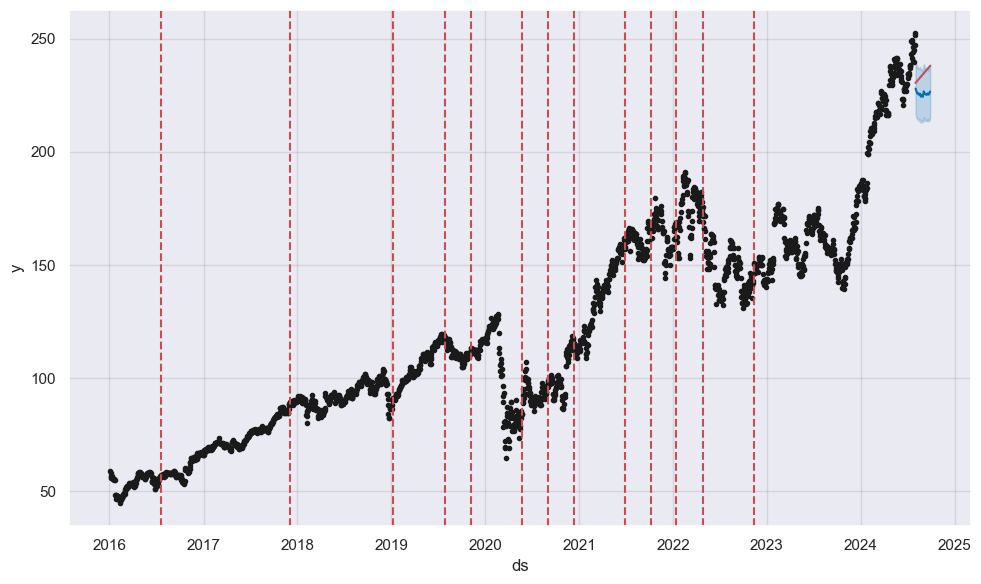

In [25]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


Zooming into forecast vs real

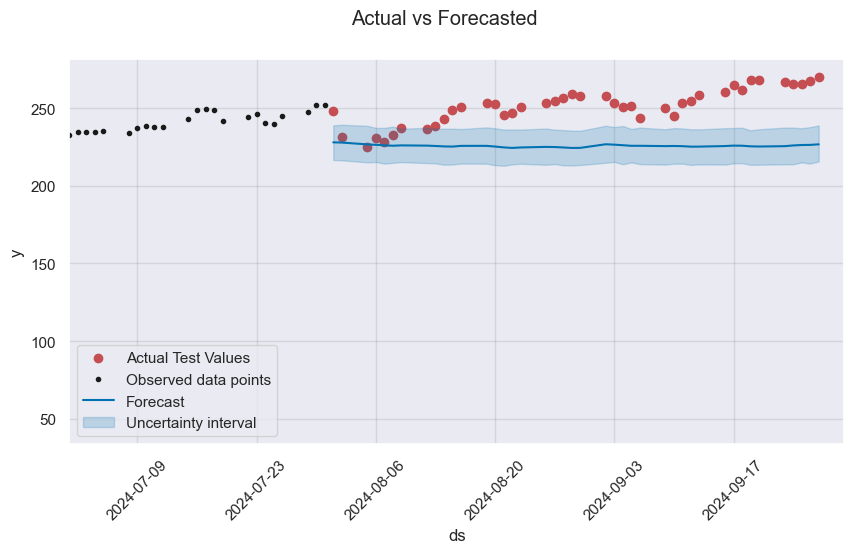

In [26]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(stock_test2.ds, stock_test2['y'], color='r', label= 'Actual Test Values')
fig = m.plot(forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2024-07-01'),
              upper=pd.to_datetime('2024-09-30'))
# ax.set_ylim(55, 90)
plt.xticks(rotation=45)
ax.legend(loc='lower left') 
plot = plt.suptitle('Actual vs Forecasted')


In [27]:
# EVALUATE WITH ERROR METRICS 
mse=np.sqrt(mean_squared_error(y_true=stock_test2['y'],y_pred=forecast['yhat']))

mae = mean_absolute_error(y_true=stock_test2['y'],
                   y_pred=forecast['yhat'])

mape = mean_absolute_percentage_error(y_true=stock_test2['y'],
                   y_pred=forecast['yhat'])

print(mse,mae, mape)

28.245964375602323 25.72974349599352 10.037692965106048


Visualizing Trend, Seasonal, and Holiday Components. As well as additional variables.

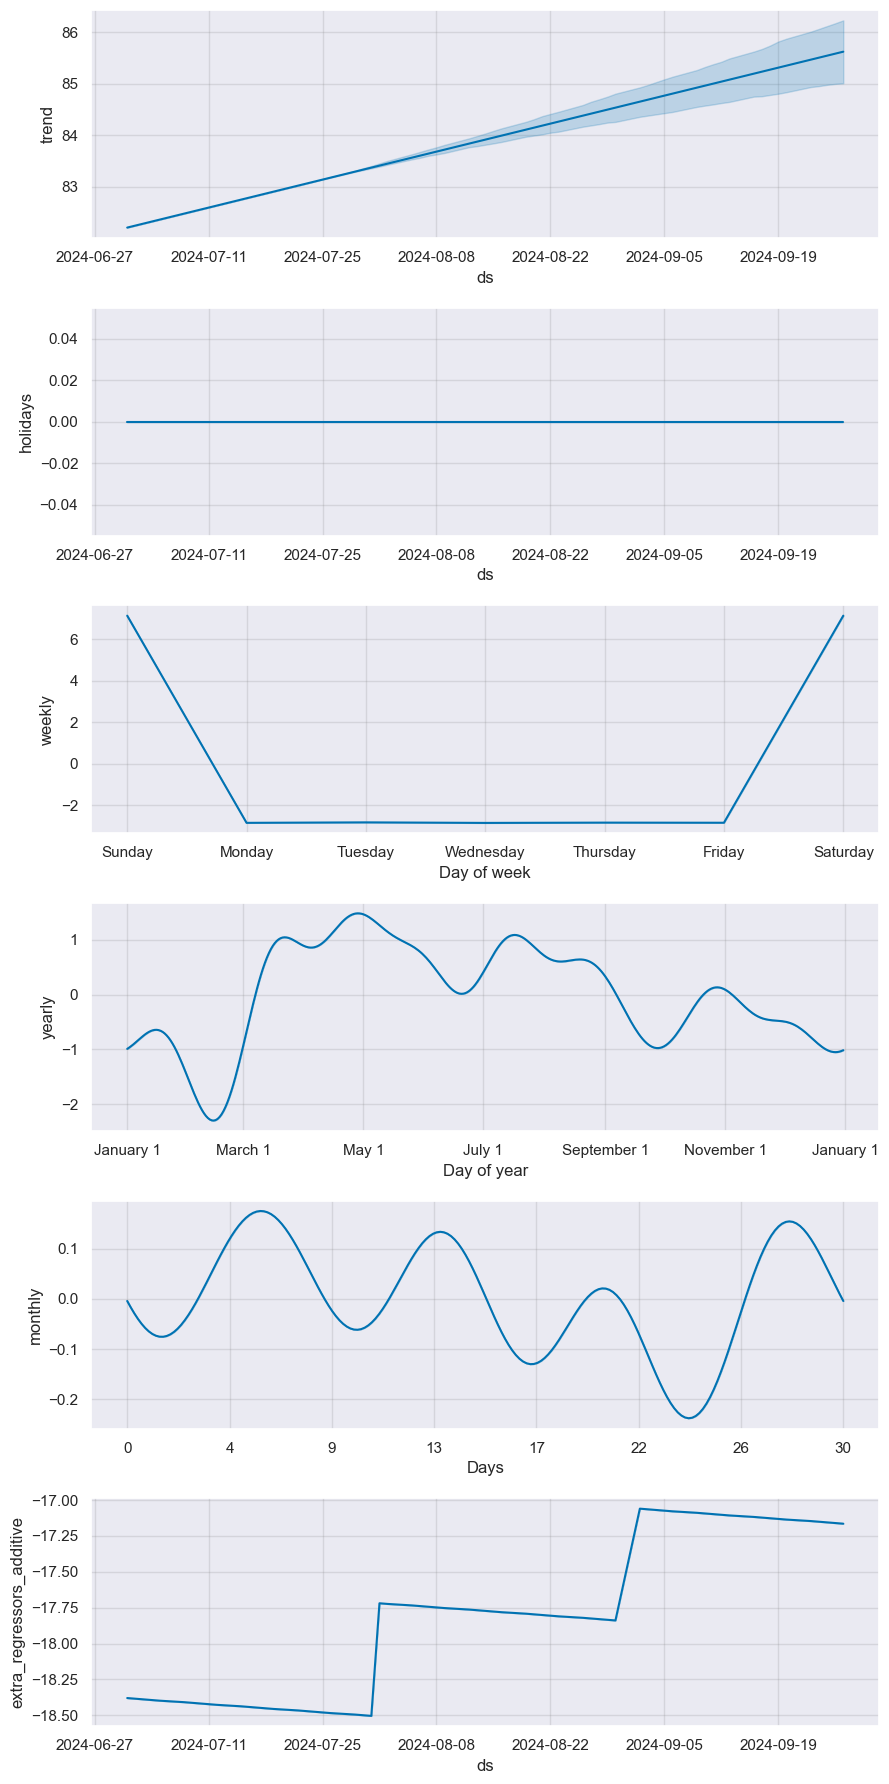

In [15]:
# PRINTING COMPONENTS OF MODEL
m.plot_components(forecast)
plt.show()

## Cross Validation

### Test Horizon for Forecast

In [20]:

# Python
from prophet.diagnostics import cross_validation
cutoffs = pd.to_datetime(['2024-02-29','2023-12-31','2023-10-31'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='90 days')


  0%|          | 0/3 [00:00<?, ?it/s]12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:02<00:05,  3.00s/it]12:10:55 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:05<00:02,  2.63s/it]12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


In [31]:
# Python
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.loc[df_p.horizon.isin(['30 days','60 days','90 days'])]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
21,30 days,8.153624,2.855455,2.396070,0.042954,0.051714,0.043217,0.350877
51,60 days,9.832749,3.135721,2.713415,0.047391,0.031788,0.048597,0.526316
81,90 days,31.872343,5.645560,4.718320,0.075167,0.093002,0.079352,0.315789


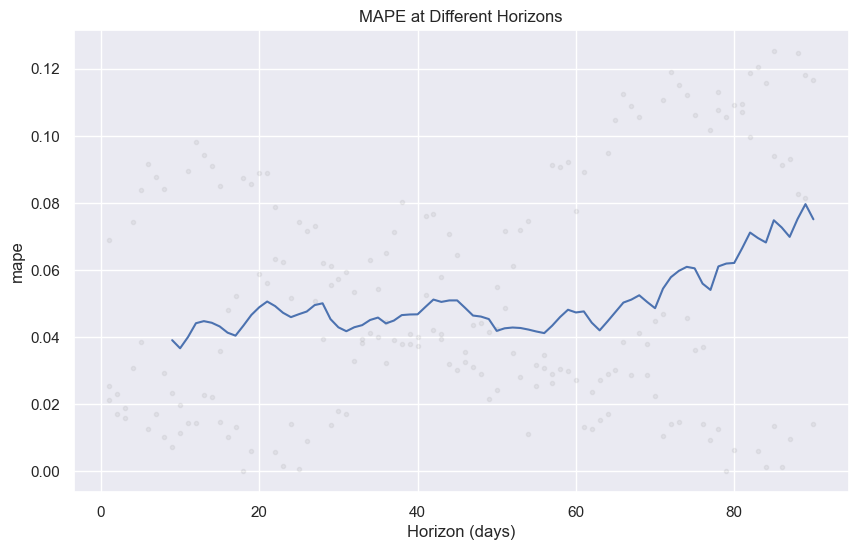

In [32]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv2, metric='mape')
plt.title('MAPE at Different Horizons')
plt.show()

**MAPE basically shoots up starting at 60 day horizon.** <br>
Reason why I decided to stay within 60 day Horizon ↑ 

### CV for Hyperparameter Tuning

#### From Prophet's Documentation
https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation

##### What parameters to Optimize?

- <u>changepoint_prior_scale:</u> This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

- <u>seasonality_prior_scale:</u> This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

- <u>holidays_prior_scale:</u> This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

- <u>seasonality_mode:</u> Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

- <u>changepoint_range:</u> This is the proportion of the history in which the trend is allowed to change. This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn’t enough runway left to fit it well. With a human in the loop, this is something that can be identified pretty easily visually: one can pretty clearly see if the forecast is doing a bad job in the last 20%. In a fully-automated setting, it may be beneficial to be less conservative. It likely will not be possible to tune this parameter effectively with cross validation over cutoffs as described above. The ability of the model to generalize from a trend change in the last 10% of the time series will be hard to learn from looking at earlier cutoffs that may not have trend changes in the last 10%. So, this parameter is probably better not tuned, except perhaps over a large number of time series. In that setting, [0.8, 0.95] may be a reasonable range.

In [34]:
import itertools
stock_hist_daily2=stock_hist_daily1.reset_index().rename(columns={'Date':'ds',stock:'y'}).copy()
date_train_test = '2024-08-31'
stock_train2=stock_hist_daily2.loc[stock_hist_daily2.ds<=date_train_test].copy()
stock_test2=stock_hist_daily2.loc[stock_hist_daily2.ds>date_train_test].copy()

## COVID
# Python
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1,0.2,0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1, 5],
    'changepoint_range': [0.8,0.9,0.95],
    'seasonality_mode': ['additive','multiplicative']    
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

## END COVID 
cutoffs = pd.to_datetime(['2024-02-29','2023-12-31','2023-10-31'])


def fit_and_evaluate(params):
    m = Prophet(**params, holidays=lockdowns)
    m.add_regressor('day')
    m.add_regressor('day_of_week')
    m.add_regressor('day_of_year')
    m.add_regressor('week_of_year')
    m.add_regressor('month')
    m.add_regressor('quarter')
    m.add_regressor('year')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(stock_train2)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='60 days')
    df_p = performance_metrics(df_cv, rolling_window=1, metrics=['rmse', 'mape'])
    return df_p['rmse'].values[0]

# Store the RMSEs for each params here
rmses = [fit_and_evaluate(params) for params in all_params]

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results.sort_values('rmse')

12:21:25 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 -

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,seasonality_mode,rmse
144,0.5,0.01,0.8,additive,2.776688
150,0.5,0.05,0.8,additive,2.790401
162,0.5,0.50,0.8,additive,2.792585
156,0.5,0.10,0.8,additive,2.797625
168,0.5,1.00,0.8,additive,2.801658
...,...,...,...,...,...
165,0.5,0.50,0.9,multiplicative,7.241477
135,0.2,1.00,0.9,multiplicative,7.331239
141,0.2,5.00,0.9,multiplicative,7.387254
171,0.5,1.00,0.9,multiplicative,7.391932


**Important** Code above took 41 minutes to run

In [35]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,seasonality_mode,rmse
144,0.5,0.01,0.8,additive,2.776688
150,0.5,0.05,0.8,additive,2.790401
162,0.5,0.50,0.8,additive,2.792585
156,0.5,0.10,0.8,additive,2.797625
168,0.5,1.00,0.8,additive,2.801658
...,...,...,...,...,...
165,0.5,0.50,0.9,multiplicative,7.241477
135,0.2,1.00,0.9,multiplicative,7.331239
141,0.2,5.00,0.9,multiplicative,7.387254
171,0.5,1.00,0.9,multiplicative,7.391932


From the code above we see the best params are:
- changepoint_prior_scale = 0.5 (Prophet's default is 0.05)
- seasonality_prior_scale  = 0.01  (Prophet's default is 10)
- changepoint_range = 0.8 (Prophet's default is 0.8)
- seasonality_mode = additive (Prophet's defeault is additive)

We will now train a model with best params

#### Training and Forecasting After Hyperparam Tuning

In [36]:
import itertools
stock_hist_daily2=stock_hist_daily1.reset_index().rename(columns={'Date':'ds',stock:'y'}).copy()
date_train_test = '2024-07-31'
stock_train2=stock_hist_daily2.loc[stock_hist_daily2.ds<=date_train_test].copy()
stock_test2=stock_hist_daily2.loc[stock_hist_daily2.ds>date_train_test].copy()

## COVID
# Python
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days


best_results = tuning_results.sort_values('rmse').head(1)

param_grid = {  
    'changepoint_prior_scale': best_results['changepoint_prior_scale'].values,
    'seasonality_prior_scale': best_results['seasonality_prior_scale'].values,
    'changepoint_range': best_results['changepoint_range'].values
    
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

m = Prophet(**all_params[0], holidays=lockdowns, seasonality_mode='additive')    
m.add_regressor('day', mode='additive')
m.add_regressor('day_of_week',mode='additive')
m.add_regressor('day_of_year',mode='additive')
m.add_regressor('week_of_year',mode='additive')
m.add_regressor('month',mode='additive')
m.add_regressor('quarter',mode='additive')
m.add_regressor('year',mode='additive')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(stock_train2)

forecast = m.predict(stock_test2)

13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# EVALUATE WITH ERROR METRICS 
mse=np.sqrt(mean_squared_error(y_true=stock_test2['y'],y_pred=forecast['yhat']))

mae = mean_absolute_error(y_true=stock_test2['y'],
                   y_pred=forecast['yhat'])

mape = mean_absolute_percentage_error(y_true=stock_test2['y'],
                   y_pred=forecast['yhat'])

print(mse,mae, mape)

10.139773282309797 9.076596669838576 11.730060009344882


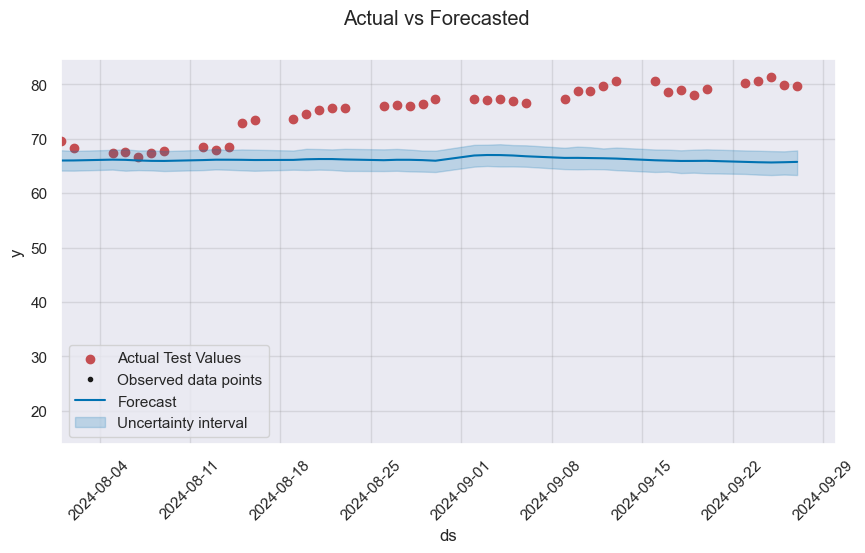

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(stock_test2.ds, stock_test2['y'], color='r', label= 'Actual Test Values')
fig = m.plot(forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2024-08-01'),
              upper=pd.to_datetime('2024-09-30'))
#ax.set_ylim(70, 90)
plt.xticks(rotation=45)
ax.legend(loc='lower left') 
plot = plt.suptitle('Actual vs Forecasted')